In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path = '/content/gdrive/My Drive/ECE763/'
import numpy as np
import cv2
from scipy.stats import multivariate_normal
from scipy.special import psi, gammaln
from scipy.optimize import fminbound
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import random
np.random.seed(2)
facetrain= np.load(path+'MyData4/ftrain.npy')
nonfacetrain= np.load(path+'MyData4/nftrain.npy')
facetest= np.load(path+'MyData4/ftest.npy')
nonfacetest= np.load(path+'MyData4/nftest.npy')


Mounted at /content/gdrive


In [0]:
def apply_pca_and_standardize(data,size):
    pca = PCA(n_components=size)
    pca.fit(data)
    data_pca = pca.transform(data)
    scaler = StandardScaler()
    scaler.fit(data_pca)
    data_std = scaler.transform(data_pca)
    return data_std,pca

In [0]:
size = 30
# pca_face = PCA(size)
facetrain_pca,pcaft = apply_pca_and_standardize(facetrain,size) 
nonfacetrain_pca,pcanft = apply_pca_and_standardize(nonfacetrain,size) 
facetest_pca,pcaftest  = apply_pca_and_standardize(facetest,size)
nonfacetest_pca,pcaftrain  = apply_pca_and_standardize(nonfacetest,size)

In [0]:
#plt.imshow(np.reshape(nonfacetrain[105],(20,20,3)).astype('uint8'))

In [0]:

facetrain_pca = facetrain
nonfacetrain_pca = nonfacetrain
facetest_pca = facetest
nonfacetest_pca = nonfacetest

In [0]:
mu_face    = facetrain_pca.mean(axis=0)
mu_nonface = nonfacetrain_pca.mean(axis=0)
var_face = np.cov(facetrain_pca, rowvar=False, bias=1, ddof=None)
var_face = np.diagonal(var_face)
var_face = np.diag(var_face,0)
var_nonface = np.cov(nonfacetrain_pca, rowvar=False, bias=1, ddof=None)
var_nonface = np.diagonal(var_nonface)
var_nonface = np.diag(var_nonface,0)

In [0]:
def plotmu(mean,dimm):
  mu = mean / np.max(mean)
  mu_mat = np.reshape(mu,(dimm,dimm,3))
  r = 200.0 / mu_mat.shape[1]
  dim = (200, int(mu_mat.shape[0] * r))
  resized = cv2.resize(mu_mat, dim, interpolation = cv2.INTER_AREA)
  plt.imshow(resized)
def plotsig(sigma,dimm):
  sigma = np.diag(sigma)
  sig = sigma / np.max(sigma)
  sig_mat = np.reshape((sig),(dimm,dimm,3))
  r = 200.0 / sig_mat.shape[1]
  dim = (200, int(sig_mat.shape[0] * r))
  resized = cv2.resize(sig_mat, dim, interpolation = cv2.INTER_AREA)
  plt.imshow(resized)


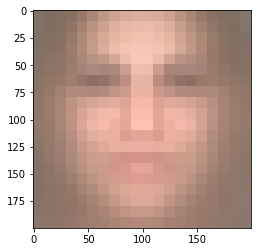

In [0]:
plotmu(mu_face,20)


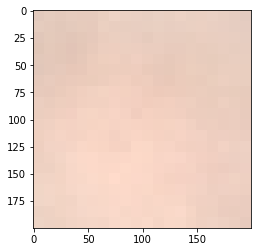

In [0]:
plotmu(mu_nonface,20)


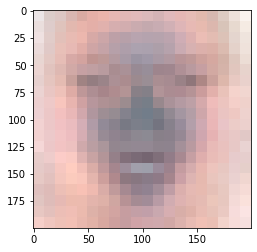

In [0]:
plotsig(var_face,20)

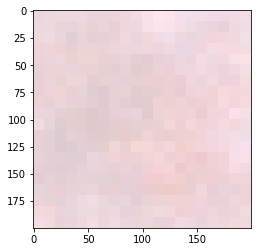

In [0]:
plotsig(var_nonface,20)

In [0]:
size = 30
pca_face = PCA(size)
facetrain_pca = pca_face.fit_transform(facetrain) 
nonfacetrain_pca = pca_face.fit_transform(nonfacetrain) 
facetest_pca  = pca_face.fit_transform(facetest)
nonfacetest_pca  = pca_face.fit_transform(nonfacetest)
mu_face    = facetrain_pca.mean(axis=0)
mu_nonface = nonfacetrain_pca.mean(axis=0)
var_face = np.cov(facetrain_pca, rowvar=False, bias=1, ddof=None)
var_face = np.diagonal(var_face)
var_face = np.diag(var_face,0)
var_nonface = np.cov(nonfacetrain_pca, rowvar=False, bias=1, ddof=None)
var_nonface = np.diagonal(var_nonface)
var_nonface = np.diag(var_nonface,0)

In [0]:
prob_fpf = multivariate_normal.pdf(facetest_pca, mean=mu_face, cov=var_face,allow_singular=True)
prob_fnpf = multivariate_normal.pdf(facetest_pca, mean=mu_nonface, cov=var_nonface,allow_singular=True)
total1 = prob_fpf + prob_fnpf
Pr1 = prob_fpf / total1
True_positive = np.sum(Pr1[:] >= 0.5)
False_negative = 100 - True_positive 

prob_nfpf = multivariate_normal.pdf(nonfacetest_pca, mean=mu_face, cov=var_face,allow_singular=True)
prob_nfnpf = multivariate_normal.pdf(nonfacetest_pca, mean=mu_nonface, cov=var_nonface,allow_singular=True)
total2 = prob_nfpf + prob_nfnpf
Pr2 = prob_nfnpf / total2
True_negative = np.sum(Pr2[:] >= 0.5)
False_positive = 100 - True_negative

fpr =  False_positive/ (False_positive + True_negative)
fnr =  False_negative / (False_negative + True_positive)
miss = ( False_positive+ False_negative) / 200

print('False Positive Rate:',fpr)
print('False Negative Rate:',fnr)
print('Miss Classification Rate:', miss)

False Positive Rate: 0.44
False Negative Rate: 0.41
Miss Classification Rate: 0.425


In [0]:
labels = np.array([np.ones(100),np.zeros(100)])
labels = np.reshape(labels,(200))
X_test_roc = np.array([facetest_pca,nonfacetest_pca])
X_test_roc = np.reshape(X_test_roc,(200,size))

In [0]:
prob_fpf_Roc = multivariate_normal.pdf(X_test_roc, mean=mu_face, cov=var_face)
prob_fnpf_Roc = multivariate_normal.pdf(X_test_roc, mean=mu_nonface, cov=var_nonface)
total_Roc = prob_fpf_Roc + prob_fnpf_Roc
P_Roc = prob_fpf_Roc / total_Roc


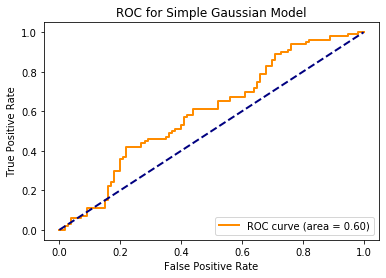

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(labels,P_Roc)
roc_auc = roc_auc_score(labels,P_Roc)
plt.plot(fpr, tpr,color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Simple Gaussian Model')
plt.legend(loc="lower right")

In [0]:
# facetraing = []
# nonfacetraing = [] 
# facetestg = []
# nonfacetestg = []
# for i in range(1000):
#   image = np.reshape(facetrain[i],(20,20,3))
#   gray = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY)
#   facetraing.append(gray)
#   image = np.reshape(nonfacetrain[i],(20,20,3))
#   gray = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY)
#   nonfacetraing.append(gray)
# for i in range(100):
#   image = np.reshape(facetest[i],(20,20,3))
#   gray = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY)
#   facetestg.append(gray)
#   image = np.reshape(nonfacetest[i],(20,20,3))
#   gray = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY)
#   nonfacetraing.append(gray)
# facetraing = np.array(facetraing)
# nonfacetraing = np.array(nonfacetraing)
# facetestg = np.array(facetestg)
# nonfacetestg = np.array(nonfacetestg)

In [0]:
# path = '/content/gdrive/My Drive/ECE763/'
# np.save(path+'MyData4/ftraing',facetraing)
# np.save(path+'MyData4/nftraing',nonfacetraing)
